In [23]:
import os
import torch
import numpy as np
from transformers import (
    AutoImageProcessor,
    MobileViTForImageClassification,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset
import evaluate

#codebase for images at https://www.kaggle.com/datasets/convolutionalboi/oral-dataset-cleaned

data_dir = "/home/yashwardhan/Downloads/archive"

dataset = load_dataset("imagefolder", data_dir=data_dir)

temp_split = dataset["train"].train_test_split(test_size=0.2, seed=42)

final_splits = temp_split["test"].train_test_split(test_size=0.5, seed=42)

dataset = {
    "train": temp_split["train"],
    "validation": final_splits["train"], 
    "test": final_splits["test"]
}

from datasets import DatasetDict
dataset = DatasetDict(dataset)


labels = dataset["train"].features["label"].names
NUM_LABELS = len(labels)
print(f"Detected labels: {labels}")
print(f"Split sizes: Train={len(dataset['train'])}, Val={len(dataset['validation'])}, Test={len(dataset['test'])}")



Detected labels: ['Calculus', 'Data caries', 'Gingivitis', 'Mouth Ulcer', 'Tooth Discoloration', 'hypodontia']
Split sizes: Train=9322, Val=1165, Test=1166


In [25]:

image_processor = AutoImageProcessor.from_pretrained("apple/mobilevit-small")

def transform(example_batch):
    try:
        images = [np.array(img.convert('RGB')) for img in example_batch["image"]]
        
        inputs = image_processor(images, return_tensors="pt")
        
        example_batch.pop("image", None)
        
        example_batch["pixel_values"] = inputs["pixel_values"]
        return example_batch
    except Exception as e:
        print(f"Error processing image batch: {e}")
        raise

dataset = dataset.with_transform(transform)

model = MobileViTForImageClassification.from_pretrained(
    "apple/mobilevit-small",
    num_labels=NUM_LABELS,
    id2label={str(i): label for i, label in enumerate(labels)},
    label2id={label: str(i) for i, label in enumerate(labels)},
    ignore_mismatched_sizes=True
)


training_args = TrainingArguments(
    output_dir="./oral_disease_mobilevit",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="steps",
    eval_steps=100,        
    save_steps=100,         
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    remove_unused_columns=False, 
    push_to_hub=False
)

accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([6, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/yashwardhan/miniconda3/envs/pdfgpt/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
from transformers import TrainingArguments, Trainer, TrainerCallback
class CustomLogger(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            print(f"Step {state.global_step}: {logs}")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    callbacks=[CustomLogger()] 
)

print("Starting training...")
train_results = trainer.train()
trainer.save_model()

print("Evaluating the model...")
eval_metrics = trainer.evaluate()
print("Evaluation metrics:", eval_metrics)

/tmp/ipykernel_8445/3587431342.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


Step,Training Loss,Validation Loss,Accuracy
100,1.508600,1.353925,0.608584
200,1.194400,1.044582,0.699571
300,0.912900,0.754219,0.779399
400,0.698900,0.560442,0.812876
500,0.552700,0.466022,0.840343
600,0.504800,0.406845,0.854077
700,0.444100,0.363378,0.867811
800,0.404200,0.344410,0.871245
900,0.399400,0.321809,0.876395
1000,0.355200,0.314849,0.881545


Step 50: {'loss': 1.7134, 'grad_norm': 1.67080557346344, 'learning_rate': 4.8287671232876716e-05, 'epoch': 0.17123287671232876}
Step 100: {'loss': 1.5086, 'grad_norm': 1.5401822328567505, 'learning_rate': 4.657534246575342e-05, 'epoch': 0.3424657534246575}
Step 100: {'eval_loss': 1.3539247512817383, 'eval_accuracy': 0.6085836909871245, 'eval_runtime': 6.6389, 'eval_samples_per_second': 175.48, 'eval_steps_per_second': 5.573, 'epoch': 0.3424657534246575}
Step 150: {'loss': 1.3497, 'grad_norm': 1.749637246131897, 'learning_rate': 4.486301369863014e-05, 'epoch': 0.5136986301369864}
Step 200: {'loss': 1.1944, 'grad_norm': 2.2701542377471924, 'learning_rate': 4.3150684931506855e-05, 'epoch': 0.684931506849315}
Step 200: {'eval_loss': 1.0445823669433594, 'eval_accuracy': 0.6995708154506438, 'eval_runtime': 6.7343, 'eval_samples_per_second': 172.995, 'eval_steps_per_second': 5.494, 'epoch': 0.684931506849315}
Step 250: {'loss': 1.0587, 'grad_norm': 1.7821156978607178, 'learning_rate': 4.14383

Step 1460: {'eval_loss': 0.2938929796218872, 'eval_accuracy': 0.8892703862660944, 'eval_runtime': 6.6752, 'eval_samples_per_second': 174.527, 'eval_steps_per_second': 5.543, 'epoch': 5.0}
Evaluation metrics: {'eval_loss': 0.2938929796218872, 'eval_accuracy': 0.8892703862660944, 'eval_runtime': 6.6752, 'eval_samples_per_second': 174.527, 'eval_steps_per_second': 5.543, 'epoch': 5.0}


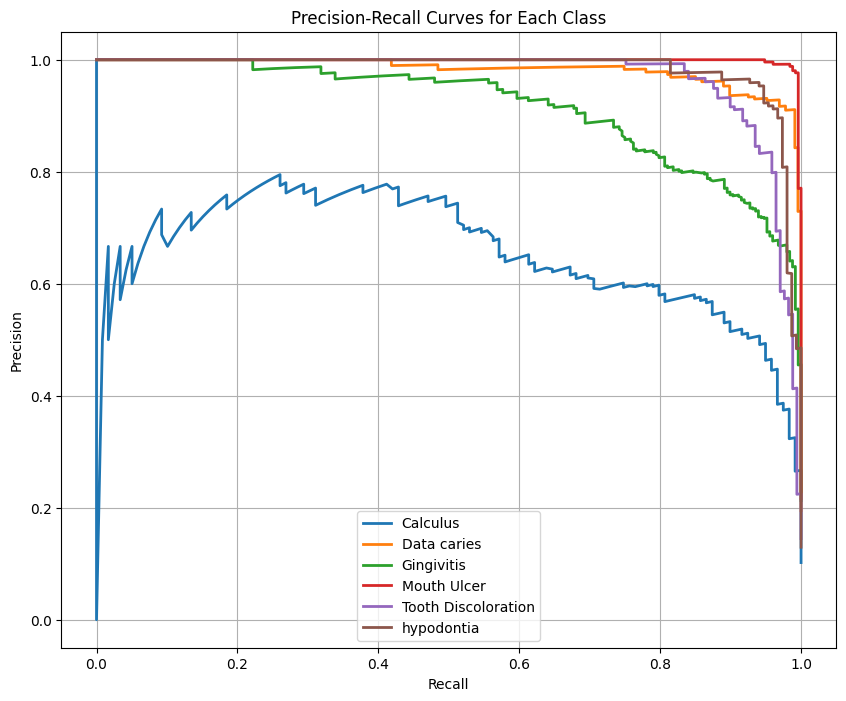

In [33]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


test_predictions = trainer.predict(dataset["test"])
logits = test_predictions.predictions
labels = test_predictions.label_ids

class_names = dataset["test"].features["label"].names

probabilities = np.exp(logits) / np.sum(np.exp(logits), axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(labels == i, probabilities[:, i])
    plt.plot(recall, precision, lw=2, label=class_name)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend()
plt.grid(True)
plt.show()


In [4]:
from transformers import MobileViTForImageClassification, AutoImageProcessor
import torch

checkpoint_path = "/home/yashwardhan/Downloads/oral_disease_mobilevit/checkpoint-5830"
model = MobileViTForImageClassification.from_pretrained(checkpoint_path)
image_processor = AutoImageProcessor.from_pretrained(checkpoint_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
model.eval()




MobileViTForImageClassification(
  (mobilevit): MobileViTModel(
    (conv_stem): MobileViTConvLayer(
      (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SiLU()
    )
    (encoder): MobileViTEncoder(
      (layer): ModuleList(
        (0): MobileViTMobileNetLayer(
          (layer): ModuleList(
            (0): MobileViTInvertedResidual(
              (expand_1x1): MobileViTConvLayer(
                (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                (activation): SiLU()
              )
              (conv_3x3): MobileViTConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
                (no